In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [6]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [7]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


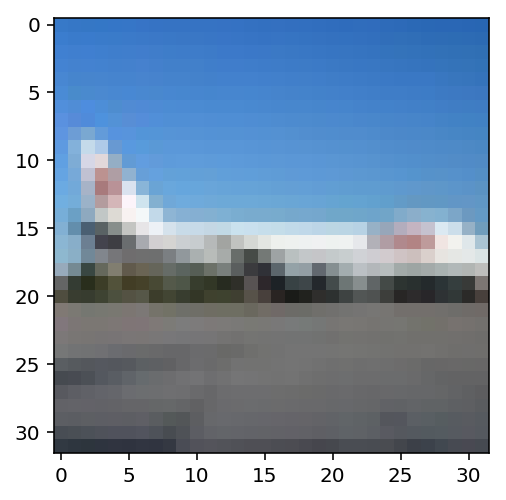

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)


In [27]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

In [30]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

In [31]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [32]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [33]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [11]:
import tensorflow as tf
import tensornets as nets

Instructions for updating:
Use the retry module or similar alternatives.


VGG16 model
- input image: 

In [12]:
x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name='input_x')
y = tf.placeholder(tf.float32, shape=(None, 10), name='output_y')

In [14]:
model = nets.VGG16(x, is_training=True, classes=10)

In [16]:
loss = tf.losses.softmax_cross_entropy(y, model)

In [17]:
train = tf.train.AdamOptimizer(learning_rate=1e-5).minimize(loss)

In [18]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    loss = sess.run(cost, 
                    feed_dict={
                        x: feature_batch,
                        y: label_batch,
                        keep_prob: 1.
                    })
    valid_acc = sess.run(accuracy, 
                         feed_dict={
                             x: valid_features,
                             y: valid_labels,
                             keep_prob: 1.
                         })
    
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

In [35]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [36]:
def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [37]:
epochs = 10
batch_size = 128

In [40]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(train, {x: batch_features, y: batch_labels})
                
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...


KeyboardInterrupt: 

In [ ]:
with tf.Session() as sess:
    nets.pretrained(model)
    # for (x, y) in your NumPy data (the NHWC and one-hot format):
        sess.run(train, {inputs: x, outputs: y})